# Predictive Maintenance



In this notebook, using [the predictive maintenance dataset from Microsoft](https://gallery.azure.ai/Experiment/Predictive-Maintenance-Implementation-Guide-Data-Sets-1), exact failure times will be predicted for up to ten days.

For this purpose, using Keras with TensorFlow, a neural network architecture with GRU and Attention layers will be built.

Using the sequential sensory data, this model will learn to predict [Weibull distribution](https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/) parameters in order to compute the remaining days to the failure.

## Data

Please uncomment and run if you don't have the data in the repository.


In [1]:
"""
!mkdir -p ../data/dataset &&\
cd ../data/dataset &&\
wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_telemetry.csv &&\
wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_errors.csv &&\
wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_maint.csv &&\
wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_failures.csv &&\
wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_machines.csv
"""

'\n!mkdir -p ../data/dataset &&cd ../data/dataset &&wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_telemetry.csv &&wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_errors.csv &&wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_maint.csv &&wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_failures.csv &&wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_machines.csv\n'

## Requirements

To install the requirements, please uncomment and run the cell below. Please make sure to use a virtual environment like Anaconda before installing the requirements.
We are using tensorflow-gpu v1.12.0 for this repository, because the attention layer we are using is compatible with this version.

In [2]:
#!cd .. && pip install -r requirements.txt

In [3]:
cd ../

/media/beast/ds-drive/github/predictive-maintenance/ml


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import random

from sklearn.preprocessing import normalize

from tqdm import tqdm

%matplotlib inline

tqdm.monitor_interval = 0

In [5]:
data_dir = 'data/dataset/'
model_save_dir = 'data/wtte/encoder-decoder-attention-1-multi/'

## Import tha data

In [6]:
telemetry = pd.read_csv(f'{data_dir}PdM_telemetry.csv')
failures = pd.read_csv(f'{data_dir}PdM_failures.csv')
maint = pd.read_csv(f'{data_dir}PdM_maint.csv')
machines = pd.read_csv(f'{data_dir}PdM_machines.csv')

**telemetry.csv** The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected.

**maint.csv** This file contains the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a break down. The records that are created due to break downs will be called failures which is explained in the later sections.

**machines.csv** This data set includes some information about the machines which are model type and years in service.

**failures.csv** These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Simple Visualizations

In [7]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [8]:
telemetry.machineID.nunique()

100

In [9]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [10]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [11]:
print(telemetry.machineID.nunique())
print(failures.machineID.nunique())

100
98


## Prepare the Dataset

We will convert the format of the datetime columns from object to datetime here.

In [12]:
# convert to datetime
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [13]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

In [14]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [15]:
# we have one year of time-series data from 100 machines
print(telemetry.datetime.min())
print(telemetry.datetime.max())

2015-01-01 06:00:00
2016-01-01 06:00:00


In [16]:
# failures

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print('Total number of failures: {}'.format(len(failures)))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Text(0, 0.5, 'Count')

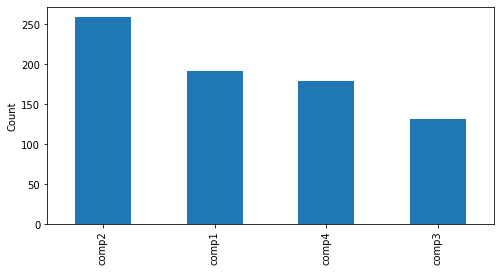

In [17]:
# Event counts for different types of failures
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')

In [18]:
# maintenance

maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

print('Total number of maintenance records: {}'.format(len(maint)))
maint.head()

Total number of maintenance records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


## Normliaze

Normalize the columns for the neural network.

In [19]:
telemetry["volt"] = (telemetry["volt"] - telemetry["volt"].mean()) / telemetry["volt"].std()
telemetry["rotate"] = (telemetry["rotate"] - telemetry["rotate"].mean()) / telemetry["rotate"].std()
telemetry["pressure"] = (telemetry["pressure"] - telemetry["pressure"].mean()) / telemetry["pressure"].std()
telemetry["vibration"] = (telemetry["vibration"] - telemetry["vibration"].mean()) / telemetry["vibration"].std()

In [20]:
# After the normalization:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,0.350769,-0.533491,1.105948,0.875673
1,2015-01-01 07:00:00,1,-0.509282,-0.832626,-0.488578,0.564015
2,2015-01-01 08:00:00,1,0.013680,1.532917,-2.318898,-1.155632
3,2015-01-01 09:00:00,1,-0.536130,-1.907127,0.759357,0.137260
4,2015-01-01 10:00:00,1,-0.849031,-0.213165,0.998127,-2.680359


In [21]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,8.761000e+05,8.761000e+05,8.761000e+05,8.761000e+05
mean,50.500000,1.789195e-15,-3.522008e-15,-3.830069e-15,3.917701e-15
std,28.866087,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,-4.735547e+00,-5.850585e+00,-4.491176e+00,-4.749765e+00
25%,25.750000,-6.752680e-01,-6.511653e-01,-6.661870e-01,-6.717814e-01
50%,50.500000,-1.098699e-02,1.809304e-02,-3.920010e-02,-2.751396e-02
75%,75.250000,6.594030e-01,6.753153e-01,6.060963e-01,6.330919e-01
max,100.000000,5.438543e+00,4.716110e+00,7.701674e+00,6.779073e+00


## Change the Life-cycle

For simplification, we will convert the 1h timesteps to 24h by computing the mean, std, min, and max values in 24 hours periods.

In [22]:
# calculate the mean, std, max, and min values for 24h periods
def timesteps_handler(df, period='24H', fields = ['volt', 'rotate', 'pressure', 'vibration']):
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').mean().unstack())
    df_mean_xh = pd.concat(temp, axis=1)
    df_mean_xh.columns = [i + '_mean_{}'.format(period.lower()) for i in fields]
    df_mean_xh.reset_index(inplace=True)

    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').std().unstack())
    df_sd_xh = pd.concat(temp, axis=1)
    df_sd_xh.columns = [i + '_sd_{}'.format(period.lower()) for i in fields]
    df_sd_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').max().unstack())
    df_max_xh = pd.concat(temp, axis=1)
    df_max_xh.columns = [i + '_max_{}'.format(period.lower()) for i in fields]
    df_max_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').min().unstack())
    df_min_xh = pd.concat(temp, axis=1)
    df_min_xh.columns = [i + '_min_{}'.format(period.lower()) for i in fields]
    df_min_xh.reset_index(inplace=True)
    
    df = pd.concat([
        df_mean_xh,
        df_sd_xh.iloc[:, 2:6],
        df_max_xh.iloc[:, 2:6],
        df_min_xh.iloc[:, 2:6]], axis=1).dropna()
    return df

In [23]:
# 24h periods
telemetry = timesteps_handler(telemetry, period='24H')
telemetry.head(10)

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,1,2015-01-02,-0.206408,-0.115613,-0.211457,-0.062451,0.599669,0.941458,0.958355,1.068717,0.771248,1.532917,1.105948,1.980589,-1.253589,-1.907127,-2.318898,-2.680359
1,1,2015-01-03,-0.063316,0.004320,-0.217588,-0.207316,1.015026,0.736613,1.057078,1.038948,1.940452,1.382994,2.367326,2.229063,-1.934438,-1.176278,-1.989187,-2.021716
2,1,2015-01-04,0.069927,0.239201,-0.258894,1.431763,0.721050,0.899648,0.804147,1.525955,1.558123,2.323109,1.371181,4.912055,-1.068951,-1.375975,-1.413025,-1.501089
3,1,2015-01-05,0.258860,0.040591,0.053726,2.198225,1.239572,0.645634,0.978183,0.946167,2.893702,1.343045,1.628682,4.111287,-2.692677,-1.545193,-1.670593,0.240185
4,1,2015-01-06,0.015518,0.156010,0.136165,0.548437,1.154196,0.907539,0.965986,1.505883,2.046716,2.447134,2.317554,3.573735,-2.812160,-1.326758,-2.003561,-1.346091
5,1,2015-01-07,0.015945,0.152053,0.137482,0.208910,1.136349,0.828651,0.773030,0.800365,2.773167,1.169388,1.646753,1.386147,-3.177165,-1.921001,-1.233135,-1.409782
6,1,2015-01-08,0.216755,-0.043045,-0.378672,0.245377,0.684218,0.748966,0.965712,1.081624,1.378338,1.865302,1.750360,2.706436,-1.233874,-1.614519,-1.877034,-2.095037
7,1,2015-01-09,0.087574,-0.009081,0.112083,-0.205391,0.891725,0.729886,0.865101,0.769713,1.931981,1.556594,1.272402,0.958858,-1.755520,-1.526450,-1.746216,-2.114125
8,1,2015-01-10,-0.092055,0.384991,-0.066108,-0.337691,0.941405,0.772227,0.766029,0.862540,1.700248,2.007974,1.475786,1.404760,-1.758397,-0.854402,-1.647746,-1.660726
9,1,2015-01-11,0.014734,0.172579,-0.106659,-0.110908,0.803475,0.626868,0.830753,1.010693,1.448955,1.423931,1.709820,1.728380,-1.579632,-0.870167,-1.838805,-1.910094


## Days past since the last replacement from maintenance

The number of the days past since the last maintanence is a good feature. We will compute and add these features here.

In [24]:
# create a column for each error type
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
36600,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0
36601,2014-07-16 06:00:00,1,0.0,0.0,0.0,1.0
36602,2014-07-31 06:00:00,1,0.0,0.0,1.0,0.0
36603,2014-12-13 06:00:00,1,1.0,0.0,0.0,0.0
0,2015-01-02 00:00:00,1,0.0,0.0,0.0,0.0


In [25]:
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = pd.to_datetime(comp_rep[comp].fillna(method="ffill"))
    
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
36600,2014-06-01 06:00:00,1,NaT,2014-06-01 06:00:00,NaT,NaT
36601,2014-07-16 06:00:00,1,NaT,2014-06-01 06:00:00,NaT,2014-07-16 06:00:00
36602,2014-07-31 06:00:00,1,NaT,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
36603,2014-12-13 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
0,2015-01-02 00:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00


In [26]:
# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]
for comp in components: 
    comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-02 00:00:00,1,19.75,214.75,154.75,169.75
1,2015-01-03 00:00:00,1,20.75,215.75,155.75,170.75
2,2015-01-04 00:00:00,1,21.75,216.75,156.75,171.75
3,2015-01-05 00:00:00,1,22.75,217.75,157.75,172.75
36604,2015-01-05 06:00:00,1,0.00,218.00,158.00,0.00


In [27]:
# normalize
comp_rep['comp1'] = (comp_rep.comp1 - comp_rep.comp1.mean()) / comp_rep.comp1.std()
comp_rep['comp2'] = (comp_rep.comp2 - comp_rep.comp2.mean()) / comp_rep.comp2.std()
comp_rep['comp3'] = (comp_rep.comp3 - comp_rep.comp3.mean()) / comp_rep.comp3.std()
comp_rep['comp4'] = (comp_rep.comp4 - comp_rep.comp4.mean()) / comp_rep.comp4.std()

In [28]:
telemetry = telemetry.merge(comp_rep, on=['datetime', 'machineID'], how='left')

In [29]:
telemetry.head()

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,...,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h,comp1,comp2,comp3,comp4
0,1,2015-01-02,-0.206408,-0.115613,-0.211457,-0.062451,0.599669,0.941458,0.958355,1.068717,...,1.105948,1.980589,-1.253589,-1.907127,-2.318898,-2.680359,-0.534309,2.766363,1.743828,1.956311
1,1,2015-01-03,-0.063316,0.004320,-0.217588,-0.207316,1.015026,0.736613,1.057078,1.038948,...,2.367326,2.229063,-1.934438,-1.176278,-1.989187,-2.021716,-0.518286,2.783267,1.760846,1.973115
2,1,2015-01-04,0.069927,0.239201,-0.258894,1.431763,0.721050,0.899648,0.804147,1.525955,...,1.371181,4.912055,-1.068951,-1.375975,-1.413025,-1.501089,-0.502263,2.800171,1.777864,1.989919
3,1,2015-01-05,0.258860,0.040591,0.053726,2.198225,1.239572,0.645634,0.978183,0.946167,...,1.628682,4.111287,-2.692677,-1.545193,-1.670593,0.240185,-0.486239,2.817076,1.794882,2.006723
4,1,2015-01-06,0.015518,0.156010,0.136165,0.548437,1.154196,0.907539,0.965986,1.505883,...,2.317554,3.573735,-2.812160,-1.326758,-2.003561,-1.346091,-0.838752,2.833980,1.811899,-0.883550


## Machine features

Additionally we have extra machine features like the age of the machines or the model. Let's add those features too. 

In [30]:
# machines

machines['model'] = machines['model'].astype('category')

print('Total number of machines: {}'.format(len(machines.index)))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [31]:
telemetry = telemetry.merge(machines, on=['machineID'], how='left')

In [32]:
model_dummies = pd.get_dummies(telemetry["model"])
telemetry = pd.concat([telemetry, model_dummies], axis=1)
telemetry.drop("model", axis=1, inplace=True)
telemetry.head()

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,...,vibration_min_24h,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,1,2015-01-02,-0.206408,-0.115613,-0.211457,-0.062451,0.599669,0.941458,0.958355,1.068717,...,-2.680359,-0.534309,2.766363,1.743828,1.956311,18,0,0,1,0
1,1,2015-01-03,-0.063316,0.004320,-0.217588,-0.207316,1.015026,0.736613,1.057078,1.038948,...,-2.021716,-0.518286,2.783267,1.760846,1.973115,18,0,0,1,0
2,1,2015-01-04,0.069927,0.239201,-0.258894,1.431763,0.721050,0.899648,0.804147,1.525955,...,-1.501089,-0.502263,2.800171,1.777864,1.989919,18,0,0,1,0
3,1,2015-01-05,0.258860,0.040591,0.053726,2.198225,1.239572,0.645634,0.978183,0.946167,...,0.240185,-0.486239,2.817076,1.794882,2.006723,18,0,0,1,0
4,1,2015-01-06,0.015518,0.156010,0.136165,0.548437,1.154196,0.907539,0.965986,1.505883,...,-1.346091,-0.838752,2.833980,1.811899,-0.883550,18,0,0,1,0


## Train, Validation, Test Split

Here we will split the dataset into training, validation and test sets without violating the order of the rows.

In [33]:
import lightgbm as lgb

# make the validation, test, and training splits
threshold_dates = [
        pd.to_datetime("2015-08-01 01:00:00"),
        pd.to_datetime("2015-11-01 01:00:00")
]

telemetry_train = telemetry[telemetry['datetime'] < threshold_dates[0]]
telemetry_valid = telemetry[
    (telemetry['datetime'] >= threshold_dates[0]) &
    (telemetry['datetime'] < threshold_dates[1])
]
telemetry_test = telemetry[(telemetry['datetime'] >= threshold_dates[1])]

failures_train = failures[failures['datetime'] < threshold_dates[0]]
failures_valid = failures[
    (failures['datetime'] >= threshold_dates[0]) &
    (failures['datetime'] < threshold_dates[1])
]
failures_test = failures[(failures['datetime'] >= threshold_dates[1])]

print(len(telemetry_train))
print(len(telemetry_valid))
print(len(telemetry_test))
print(len(failures_train))
print(len(failures_valid))
print(len(failures_test))

21200
9200
6200
458
182
121


In [34]:
telemetry_train.head()

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,...,vibration_min_24h,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,1,2015-01-02,-0.206408,-0.115613,-0.211457,-0.062451,0.599669,0.941458,0.958355,1.068717,...,-2.680359,-0.534309,2.766363,1.743828,1.956311,18,0,0,1,0
1,1,2015-01-03,-0.063316,0.004320,-0.217588,-0.207316,1.015026,0.736613,1.057078,1.038948,...,-2.021716,-0.518286,2.783267,1.760846,1.973115,18,0,0,1,0
2,1,2015-01-04,0.069927,0.239201,-0.258894,1.431763,0.721050,0.899648,0.804147,1.525955,...,-1.501089,-0.502263,2.800171,1.777864,1.989919,18,0,0,1,0
3,1,2015-01-05,0.258860,0.040591,0.053726,2.198225,1.239572,0.645634,0.978183,0.946167,...,0.240185,-0.486239,2.817076,1.794882,2.006723,18,0,0,1,0
4,1,2015-01-06,0.015518,0.156010,0.136165,0.548437,1.154196,0.907539,0.965986,1.505883,...,-1.346091,-0.838752,2.833980,1.811899,-0.883550,18,0,0,1,0


In [35]:
failures_train.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
7,2015-03-19 06:00:00,2,comp1


## Prepare the Model's Input and output

We will prepare the input X and the output y for the model. For each sample the input will have 10 sequence values with 24 features: (number_of_samples, max_time, number_of_features). The number of samples depends on how we are using the failure events. Here we will start ten days before each failure event and will decrease the days remaining in order to generate 10 different samples for each event.

In [36]:
max_time = 10

In [37]:
def data_handler(df_telemetry, df_failure):
    sample_id = 0
    #cols = ['instance', 'timesteps', 'volt', 'rotate', 'pressure', 'vibration']
    cols = [
        "instance",
        "timesteps",
        "volt_mean_24h",
        "rotate_mean_24h",
        "pressure_mean_24h",
        "vibration_mean_24h",
        "volt_sd_24h",
        "rotate_sd_24h",
        "pressure_sd_24h",
        "vibration_sd_24h",
        "volt_max_24h",
        "rotate_max_24h",
        "pressure_max_24h",
        "vibration_max_24h",
        "volt_min_24h",
        "rotate_min_24h",
        "pressure_min_24h",
        "vibration_min_24h",
        "comp1",
        "comp2",
        "comp3",
        "comp4",
        "model1",
        "model2",
        "model3",
        "model4",
    ]
    dataset = pd.DataFrame(columns=cols)
    for machine_id in df_failure.machineID.unique():
        telemetry_sample = df_telemetry[df_telemetry['machineID'] == machine_id].sort_values(by='datetime')
        sample_failure = df_failure[df_failure['machineID'] == machine_id].sort_values(by='datetime')
        
        prev_fail_datetime = pd.to_datetime("1900-01-01 00:00:00")
        for fail_datetime in sample_failure.datetime:
            temp = telemetry_sample[
                (telemetry_sample.datetime > prev_fail_datetime) &
                (telemetry_sample.datetime < fail_datetime)
            ]
            matrix = np.concatenate(
                    (
                        np.array([sample_id] * len(temp))[:, None].astype(np.int16),
                        np.arange(len(temp))[:, None].astype(np.int16),
                        temp[cols[2:]].values
                    ), axis=1
                )
            dataset = dataset.append(pd.DataFrame(matrix, columns=cols), ignore_index=True)  
            prev_fail_datetime = fail_datetime
            sample_id += 1
    dataset['instance'] = dataset['instance'].astype(np.int16)
    dataset['timesteps'] = dataset['timesteps'].astype(np.int16)
    return dataset

In [38]:
train = data_handler(telemetry_train, failures_train)
train.head()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,...,pressure_min_24h,vibration_min_24h,comp1,comp2,comp3,comp4,model1,model2,model3,model4
0,0,0,-0.206408,-0.115613,-0.211457,-0.062451,0.599669,0.941458,0.958355,1.068717,...,-2.318898,-2.680359,-0.534309,2.766363,1.743828,1.956311,0.0,0.0,1.0,0.0
1,0,1,-0.063316,0.004320,-0.217588,-0.207316,1.015026,0.736613,1.057078,1.038948,...,-1.989187,-2.021716,-0.518286,2.783267,1.760846,1.973115,0.0,0.0,1.0,0.0
2,0,2,0.069927,0.239201,-0.258894,1.431763,0.721050,0.899648,0.804147,1.525955,...,-1.413025,-1.501089,-0.502263,2.800171,1.777864,1.989919,0.0,0.0,1.0,0.0
3,0,3,0.258860,0.040591,0.053726,2.198225,1.239572,0.645634,0.978183,0.946167,...,-1.670593,0.240185,-0.486239,2.817076,1.794882,2.006723,0.0,0.0,1.0,0.0
4,1,0,0.015518,0.156010,0.136165,0.548437,1.154196,0.907539,0.965986,1.505883,...,-2.003561,-1.346091,-0.838752,2.833980,1.811899,-0.883550,0.0,0.0,1.0,0.0


In [39]:
train.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,...,pressure_min_24h,vibration_min_24h,comp1,comp2,comp3,comp4,model1,model2,model3,model4
count,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,...,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000
mean,220.032473,29.512354,0.004621,-0.005100,0.000670,0.006040,0.961285,0.949098,0.910421,0.931582,...,-1.784434,-1.822731,0.144181,0.225333,0.230956,0.211103,0.189352,0.177522,0.343767,0.289359
std,127.364437,27.259666,0.309905,0.350829,0.431764,0.393513,0.147651,0.146407,0.156813,0.151905,...,0.570619,0.557621,1.087518,1.228304,1.202577,1.178493,0.391800,0.382121,0.474979,0.453479
min,0.000000,0.000000,-0.831062,-3.329136,-0.894656,-0.776540,0.490832,0.477832,0.408542,0.459817,...,-4.489643,-4.425483,-0.838752,-0.851113,-0.876901,-0.883550,0.000000,0.000000,0.000000,0.000000
25%,118.000000,9.000000,-0.175360,-0.101429,-0.198889,-0.187471,0.858442,0.849675,0.807560,0.828834,...,-2.109577,-2.144112,-0.630449,-0.648264,-0.655671,-0.665099,0.000000,0.000000,0.000000,0.000000
50%,220.000000,22.000000,-0.035073,0.047380,-0.067252,-0.054765,0.957748,0.940979,0.898531,0.923436,...,-1.777462,-1.815517,-0.261913,-0.293278,-0.247245,-0.278609,0.000000,0.000000,0.000000,0.000000
75%,325.000000,42.000000,0.112798,0.184970,0.064948,0.086345,1.059679,1.041833,0.994532,1.022143,...,-1.487202,-1.512724,0.475159,0.602639,0.637676,0.712822,0.000000,0.000000,1.000000,1.000000
max,457.000000,190.000000,2.891123,0.888034,4.657202,3.853785,1.680149,1.630578,1.896545,1.873295,...,3.126734,2.130870,4.737357,5.031512,4.534735,4.728957,1.000000,1.000000,1.000000,1.000000


In [40]:
valid = data_handler(telemetry_valid, failures_valid)
test = data_handler(telemetry_test, failures_test)

In [41]:
valid.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,...,pressure_min_24h,vibration_min_24h,comp1,comp2,comp3,comp4,model1,model2,model3,model4
count,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,...,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.00000,5323.000000,5323.000000,5323.000000
mean,90.200451,21.806688,0.005273,-0.012744,0.014072,0.017242,0.960762,0.950756,0.910533,0.934900,...,-1.774494,-1.831799,-0.258060,-0.247974,-0.174277,-0.089807,0.20496,0.200075,0.303776,0.291189
std,52.700609,17.940442,0.312073,0.377137,0.455152,0.419158,0.143546,0.143913,0.160601,0.151170,...,0.574966,0.575655,0.561776,0.507270,0.657236,0.913680,0.40371,0.400094,0.459930,0.454353
min,0.000000,0.000000,-0.786488,-3.070367,-0.759615,-0.710328,0.505523,0.511856,0.453668,0.497622,...,-4.491176,-3.776376,-0.838752,-0.851113,-0.876901,-0.883550,0.00000,0.000000,0.000000,0.000000
25%,47.000000,8.000000,-0.170959,-0.099114,-0.192901,-0.188784,0.862967,0.850835,0.806482,0.834346,...,-2.096773,-2.167896,-0.646472,-0.648264,-0.655671,-0.665099,0.00000,0.000000,0.000000,0.000000
50%,90.000000,17.000000,-0.037012,0.051286,-0.065161,-0.054566,0.954574,0.946047,0.896558,0.926173,...,-1.782380,-1.832512,-0.406123,-0.394703,-0.366369,-0.329021,0.00000,0.000000,0.000000,0.000000
75%,135.000000,31.000000,0.115736,0.185502,0.073543,0.085421,1.053780,1.043070,0.994404,1.022950,...,-1.483642,-1.526949,-0.037587,0.027900,0.093109,0.133087,0.00000,0.000000,1.000000,1.000000
max,181.000000,89.000000,2.510818,0.813248,4.522065,3.859718,1.594128,1.925767,2.570401,1.958613,...,2.165257,2.237227,5.586592,1.667597,2.935069,5.737192,1.00000,1.000000,1.000000,1.000000


In [42]:
test.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,...,pressure_min_24h,vibration_min_24h,comp1,comp2,comp3,comp4,model1,model2,model3,model4
count,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,...,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.00000
mean,61.110043,16.585114,0.009396,-0.026072,0.028051,0.010366,0.967132,0.951355,0.915053,0.934248,...,-1.774705,-1.823089,-0.105269,-0.055387,-0.119006,-0.180957,0.216524,0.241097,0.270299,0.27208
std,36.698402,13.167817,0.328613,0.378672,0.473463,0.418482,0.145059,0.149650,0.162821,0.150391,...,0.585302,0.572959,0.669474,0.773911,0.669434,0.556571,0.411949,0.427825,0.444193,0.44511
min,0.000000,0.000000,-0.840284,-2.581586,-0.783497,-0.750155,0.529932,0.462455,0.472447,0.493792,...,-3.739298,-3.642943,-0.838752,-0.851113,-0.876901,-0.883550,0.000000,0.000000,0.000000,0.00000
25%,29.000000,6.000000,-0.173084,-0.110331,-0.195094,-0.196784,0.865344,0.849678,0.806154,0.831238,...,-2.114855,-2.162278,-0.630449,-0.631360,-0.638653,-0.665099,0.000000,0.000000,0.000000,0.00000
50%,64.000000,13.000000,-0.034235,0.038697,-0.064829,-0.064824,0.961829,0.943720,0.902813,0.923285,...,-1.776497,-1.830676,-0.277936,-0.360894,-0.298298,-0.295413,0.000000,0.000000,0.000000,0.00000
75%,93.000000,24.000000,0.112060,0.180866,0.079326,0.083347,1.061475,1.049525,0.997008,1.022121,...,-1.492448,-1.518467,0.250833,0.268783,0.212233,0.175097,0.000000,0.000000,1.000000,1.00000
max,120.000000,59.000000,2.873160,0.683332,3.962202,3.815904,1.723182,1.523572,1.737667,1.781736,...,1.413543,1.092704,7.028690,2.935404,2.424537,1.620233,1.000000,1.000000,1.000000,1.00000


In [43]:
def build_data(engine, time, x, max_time, is_test):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = np.empty((0, 2), dtype=np.float32)
    
    num_features = x.shape[1]
    engine_list = np.unique(engine)

    # A full history of sensor readings to date for each x
    out_x = np.empty((0, max_time, num_features), dtype=np.float32)

    for i in tqdm(engine_list):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1

        if is_test:
            start = random.randint(max_engine_time-10, max_engine_time-1)
            end = start + 1
        else:
            start = max_engine_time-10
            end = max_engine_time

        if start >= 0:
            this_x = np.empty((0, max_time, num_features), dtype=np.float32)

            for j in range(start, end):
                engine_x = x[engine == i]

                out_y = np.append(out_y, np.array((max_engine_time - j, 1), ndmin=2), axis=0)

                xtemp = np.zeros((1, max_time, num_features))
                xtemp[:, max_time-min(j, max_time-1)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
                this_x = np.concatenate((this_x, xtemp))

            out_x = np.concatenate((out_x, this_x))

    return out_x, out_y

In [44]:
arr_train = train.values
arr_valid = valid.values
arr_test = test.values

train_x, train_y = build_data(arr_train[:, 0], arr_train[:, 1], arr_train[:, 2:], max_time, False)
valid_x, valid_y = build_data(arr_valid[:, 0], arr_valid[:, 1], arr_valid[:, 2:], max_time, False)
test_x, test_y = build_data(arr_test[:, 0], arr_test[:, 1], arr_test[:, 2:], max_time, True)

100%|██████████| 111/111 [00:00<00:00, 22188.91it/s]


## Model

We will build a neural network architecture using GRU and Attention layer like the decoder-encoder networks. However, instead of predicting the exact values, we will predict the Weibull distribution to compute the days. The adventage of predicting the Weibull distribution is [the censored data](http://https://en.wikipedia.org/wiki/Censoring_(statistics)) can be used for training (in this solution we are not using the censored data yet).

In [45]:
num_models = 1

In [46]:
from pathlib import Path
import gc

from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, LSTM, Activation, Masking, GRU, RepeatVector
from tensorflow.python.keras.layers import TimeDistributed, Flatten, Concatenate, Input, Dropout
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import normalize

/home/beast/.conda/envs/predictive-maintenance/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/beast/.conda/envs/predictive-maintenance/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/beast/.conda/envs/predictive-maintenance/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/beas

In [47]:
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = K.pow((y_ + 1e-35) / a_, b_)
    hazard1 = K.pow((y_ + 1) / a_, b_)

    return -1 * K.mean(u_ * K.log(K.exp(hazard1 - hazard0) - 1.0) - hazard1)

def activate(ab):
    a = K.exp(ab[:, 0])
    b = K.softplus(ab[:, 1])

    a = K.reshape(a, (K.shape(a)[0], 1))
    b = K.reshape(b, (K.shape(b)[0], 1))

    return K.concatenate((a, b), axis=1)

In [48]:
# Attention layer implementation: https://github.com/thushv89/attention_keras

import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [114]:
def build_model():
    fr_timesteps = 50

    encoder_inputs = Input(shape=(max_time, 24), name='encoder_inputs')
    decoder_inputs = Input(shape=(fr_timesteps - 1, 24), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = GRU(120, recurrent_dropout=0.2, return_sequences=True, return_state=True, name='encoder_gru')
    encoder_out, encoder_state = encoder_gru(encoder_inputs)

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(120, recurrent_dropout=0.2, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(encoder_out, initial_state=encoder_state)

    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    x = Flatten()(decoder_concat_input)
    x = Dropout(0.6)(x)
    x = Dense(2)(x)
    x = Activation(activate)(x)

    # Full model
    model = Model(inputs=[encoder_inputs], outputs=x)
    model.compile(loss=weibull_loglik_discrete, metrics=['mae'], optimizer=Adam(lr=0.001))
    
    return model

In [115]:
# Model save dir.
Path(model_save_dir).mkdir(parents=True, exist_ok=True)

for i in range(num_models):
    
    print(f'Training model-{i}...')

    model = build_model()

    checkpoint = ModelCheckpoint(model_save_dir + f'model{i}.h5', monitor="val_loss", save_best_only=True, save_weights_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=18, verbose=1)
    callbacks = [reduce_lr, early_stopping, checkpoint]

    history = model.fit(
        train_x, train_y, epochs=250, batch_size=64, 
        verbose=0, validation_data=(valid_x, valid_y), callbacks=callbacks)
    
    losses = [l for l in history.history["loss"] if l > 0]
    va_losses = [l for l in history.history["val_loss"] if l > 0]
    print(f'Model-{i} trained.')
    print(f'Min. Train Loss = {min(losses)}')
    print(f'Min. Validation Loss = {min(va_losses)}')
    print('\n')
    
    K.clear_session()
    
    del model
    gc.collect()

Training model-0...

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00040: early stopping
Model-0 trained.
Min. Train Loss = 1.7712968327891288
Min. Validation Loss = 2.072065317085366




## Results

We will predict two values: alpha and beta. And these values will be used to compute the Weibull distribution.

In [116]:
test_results_dfs = []
for i in range(num_models):
    model = build_model()
    model.load_weights(model_save_dir + f'model{i}.h5')
    test_predict = model.predict(test_x)
    test_result = np.concatenate((test_y, test_predict), axis=1)
    test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])
    test_results_dfs.append(test_results_df)
    
    K.clear_session()
    del model
    gc.collect()

In [117]:
import math

In [118]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

def weibull_mode(alpha, beta):
    return alpha * ((beta-1)/beta)**(1/beta)

Compute the mode and the median from the distributions.

In [119]:
for i in range(num_models):
    test_results_dfs[i]['mode'] = weibull_mode(test_results_dfs[i]['alpha'], test_results_dfs[i]['beta'])
    test_results_dfs[i]['median'] = weibull_median(test_results_dfs[i]['alpha'], test_results_dfs[i]['beta'])
    test_results_dfs[i]['mode'].fillna(0.0)

Check the results from the model-0. The computed mode values are the predictions of the days remaining to the failures.

In [120]:
test_results_dfs[0].head(30)

,T,E,alpha,beta,mode,median
0,8.0,1.0,9.052937,4.234589,8.494968,8.302337
1,7.0,1.0,7.088796,3.506211,6.441445,6.385201
2,3.0,1.0,6.068401,3.656587,5.560688,5.489634
3,5.0,1.0,4.013860,1.902020,2.711550,3.310359
4,3.0,1.0,5.827964,3.424347,5.268875,5.236411
5,10.0,1.0,9.653652,4.530777,9.136670,8.903480
6,3.0,1.0,6.785790,3.341132,6.100540,6.080784
7,7.0,1.0,8.206334,3.812919,7.577112,7.454235
8,5.0,1.0,6.000038,3.079893,5.281979,5.326870
9,8.0,1.0,8.794358,5.983088,8.529605,8.271801


For the multiple models scenario, compute the mean of the values using the multiple results.

In [121]:
mean_df = pd.DataFrame(columns=test_results_dfs[0].columns)
for col in mean_df.columns:
    arr = np.zeros_like(test_results_dfs[0][col].values).astype(np.float32)
    for i in range(num_models):
        arr += test_results_dfs[i][col].values
    mean_df[col] = arr / float(num_models)

In [122]:
mean_df.head(30)

,T,E,alpha,beta,mode,median
0,8.0,1.0,9.052937,4.234589,8.494967,8.302337
1,7.0,1.0,7.088796,3.506211,6.441445,6.385201
2,3.0,1.0,6.068401,3.656587,5.560688,5.489634
3,5.0,1.0,4.013860,1.902020,2.711550,3.310359
4,3.0,1.0,5.827964,3.424347,5.268875,5.236411
5,10.0,1.0,9.653652,4.530777,9.136670,8.903481
6,3.0,1.0,6.785790,3.341132,6.100540,6.080783
7,7.0,1.0,8.206334,3.812919,7.577112,7.454235
8,5.0,1.0,6.000038,3.079893,5.281979,5.326870
9,8.0,1.0,8.794358,5.983088,8.529605,8.271801


## MAE Metric

Mean absolute error is a good metric to meaure the performance of the system. Here we will evaluate the model-0's results.  

First model:

In [123]:
from sklearn.metrics import mean_absolute_error

test_results_dfs[0] = test_results_dfs[0].dropna()
mean_absolute_error(test_results_dfs[0]['T'].tolist(), test_results_dfs[0]['mode'].tolist())

1.849114159191691

If mulitple models, print the ensemble results:

In [124]:
if num_models > 1:
    mean_df = mean_df.dropna()
    mean_absolute_error(mean_df['T'].tolist(), mean_df['mode'].tolist())

## Visualize the Results

Here we will draw the Weibull distributions with the grounth truth failure days.

In [125]:
palette=sns.color_palette("RdBu_r", 50)

def plot_weibull_predictions(results_df, num_samples=None):
    
    results_df = results_df[results_df.beta > 1]
    
    if num_samples:
        results_df = results_df.iloc[:num_samples]

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0, 20)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[2]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)    

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')
        
        ax.set_xlabel('Days')
        ax.set_xlabel('Confidence')
        ax.set_title('Weibull distributions')
    
    ax=axarr[1]
    
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])

    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    

    ax.legend()
    
    ax=axarr[0]
    sns.distplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')
    
    plt.show()

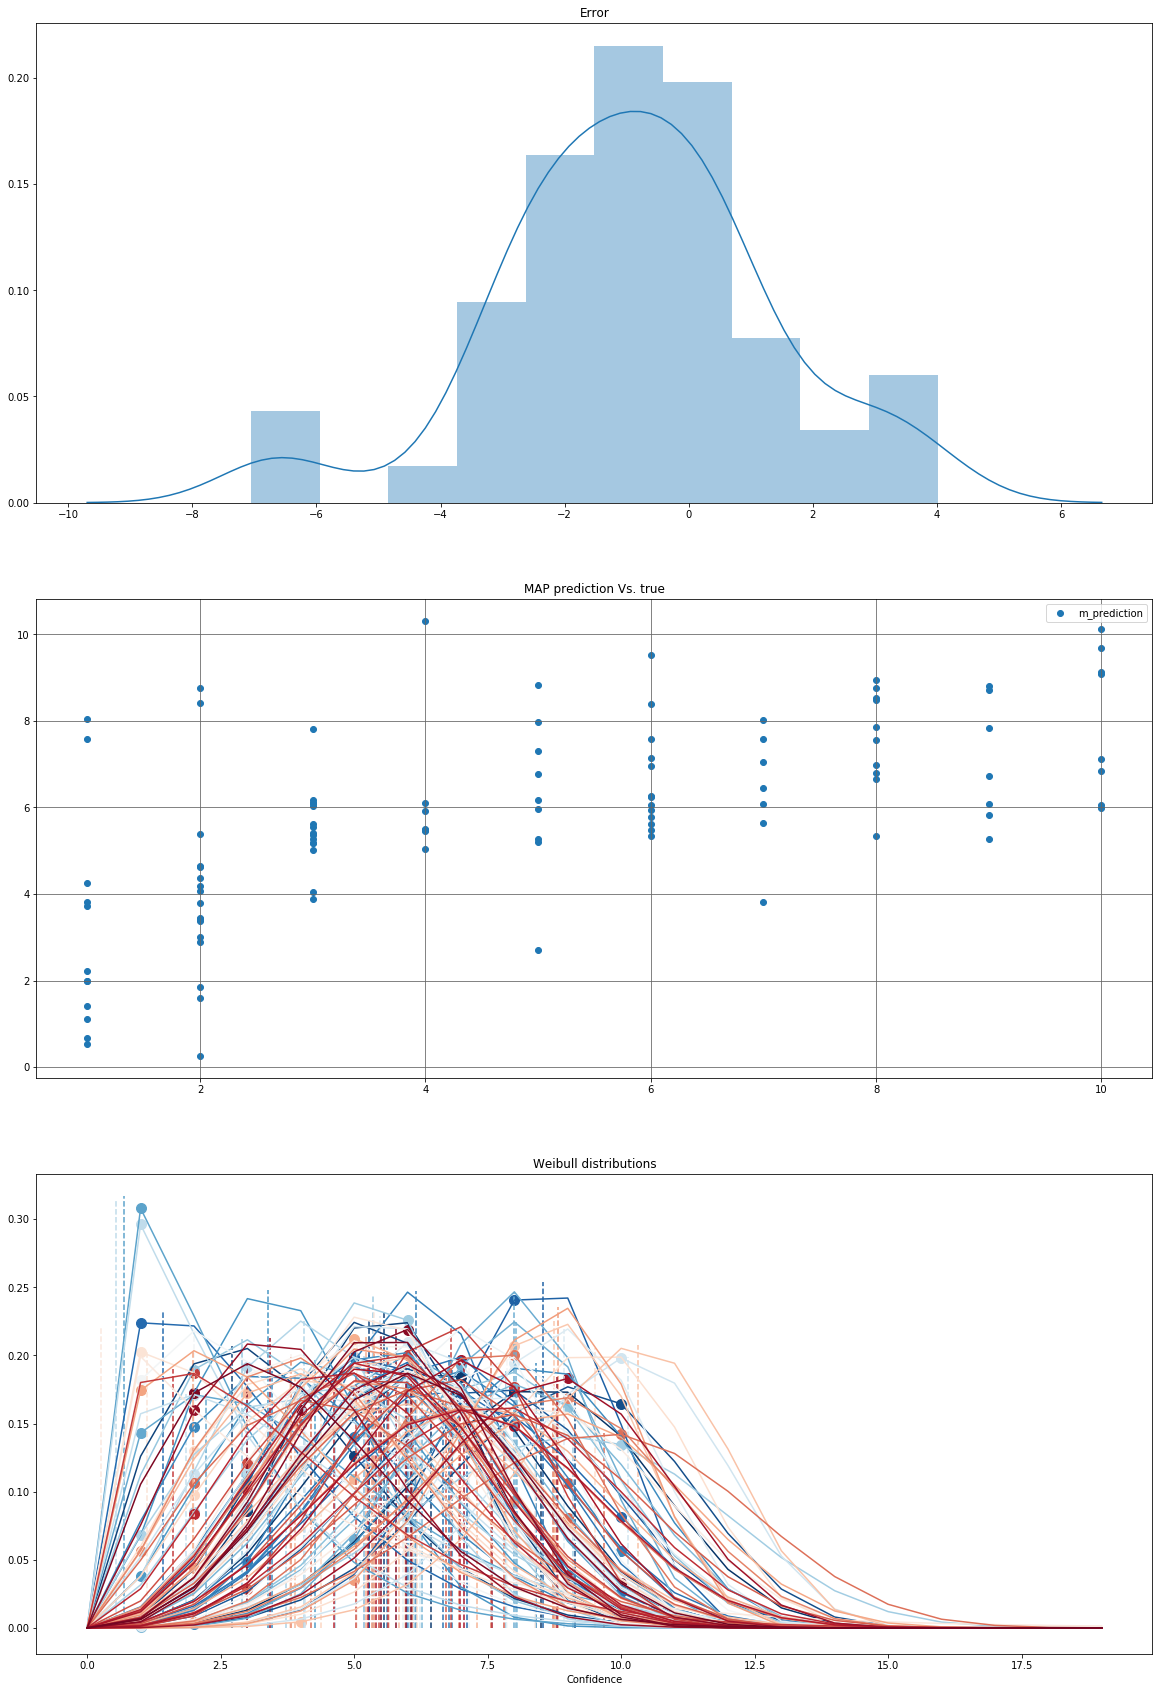

In [126]:
plot_weibull_predictions(results_df=mean_df)

Here the solid lines represent the Weibull distribution for each machine in the test set (different colors represents different machines). And the dashed lines are the modes of the distributions which indicate predictions of the remaining days to the failures. And the dots indicate the ground truth values.